In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

## Research Agent

The goal of research is to gather the context requested by the research brief.

Here is the overall research flow :

<img src="./assets/overall_flow.png" width=800/>

In [2]:
from utils import show_prompt
from deep_research_with_langgraph.prompts import research_agent_prompt
show_prompt(research_agent_prompt, "Research Agent Instructions")

╭────────────────────────────────────────── Research Agent Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

### State and Schemas

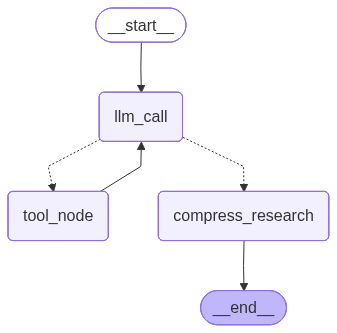

In [3]:
from IPython.display import Image, display
from deep_research_with_langgraph.research_agent import researcher_agent

# Show the agent
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

# Example brief
research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of Dec 2025."""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['researcher_messages'])

### Evals

Agents use a self-directed trajectory of tool calls to accomplish tasks.

Let's think about the ramifications of a poorly tuned tool-calling loop:
-  Early Termination: The agent decides to stop calling tools when the task is not actually complete.
-  Prolonged Looping: The agent is never satisfied with the state of its information.

The first failure mode results in the agent collecting insufficient information. In the deep research context, the answer may end up being too shallow. The second failure mode results in the agent utilizing an excessive number of tokens. In the deep research context, irrelevant information may poison the result.

We tuned our prompt to avoid these problems. But, let's set up a toy eval dataset that allows us to easily test agent decision-making.


In [5]:
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

# Scenario 1: Agent should CONTINUE - has insufficient/irrelevant information + think_tool realizes more research needed
messages_should_continue = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll search for information about top coffee shops in San Francisco focusing on coffee quality.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "coffee shops San Francisco popular locations"
                },
                "id": "call_continue_search_001",
                "type": "tool_call"
            }
        ]
    ),
    # Tavily Search provides generic cafe information - NOT focused on coffee quality
    ToolMessage(
        content="Search results show popular San Francisco cafes: Blue Bottle Coffee has great wifi and ambiance, Philz Coffee is known for custom blends and friendly service, Café Reveille has multiple locations with good pastries and laptop-friendly spaces. Ritual Coffee offers cozy seating and is popular with students.",
        tool_call_id="call_continue_search_001",
    ),
    # Agent uses think_tool to reflect and realizes the search results are insufficient
    AIMessage(
        content="Let me use the think_tool to analyze these search results and determine next steps.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality."
                },
                "id": "call_continue_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response identifies the gap and need for more targeted research
    ToolMessage(
        content="Reflection recorded: Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality.",
        tool_call_id="call_continue_think_001",
    )
]

# Scenario 2: Agent should STOP - has comprehensive coffee quality information + think_tool reflection
messages_should_stop = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll research San Francisco coffee shops specifically focusing on coffee quality assessments and expert reviews.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "best coffee quality San Francisco specialty coffee expert reviews Coffee Review ratings 2024"
                },
                "id": "call_stop_search_001", 
                "type": "tool_call"
            }
        ]
    ),
    # This ToolMessage provides COMPREHENSIVE coffee quality information - sufficient to answer the question
    ToolMessage(
        content="""Coffee quality research for San Francisco reveals top establishments based on expert reviews and specialty coffee credentials:

**Top Quality-Focused Coffee Shops:**
1. **Sightglass Coffee** - Coffee Review score 94/100, known for single-origin beans and precise roasting techniques. Featured in Bon Appétit's "Best Coffee in America" list for exceptional coffee quality.

2. **Saint Frank Coffee** - Ranked #3 coffee shop in America by The Daily Meal based on coffee quality. 4.3/5 Yelp rating with reviews specifically praising "exceptional bean quality" and "perfect extraction."

3. **Ritual Coffee Roasters** - Specialty Coffee Association member, direct trade relationships, consistently rated 4.4/5 on Google with reviews highlighting "superior coffee taste" and "expert barista skills."

4. **Blue Bottle Coffee** - Third-wave coffee pioneer, Coffee Review scores averaging 90+/100, known for rigorous quality control and fresh roasting practices.

5. **Four Barrel Coffee** - Local roaster with Coffee Review scores 88-92/100, praised by industry experts for "exceptional coffee quality" and innovative brewing methods.

**Quality Indicators Found:**
- Coffee Review professional scores (88-94/100 range)
- Specialty Coffee Association certifications
- Direct trade/single-origin sourcing
- Expert recognition from food publications
- Customer reviews specifically mentioning coffee taste and quality

This provides a comprehensive assessment of SF coffee shops based specifically on coffee quality rather than ambiance or service.""",
        tool_call_id="call_stop_search_001",
    ),
    # Agent now uses think_tool to reflect on the search results
    AIMessage(
        content="Let me reflect on the search results using the think_tool to assess whether I have sufficient information.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now."
                },
                "id": "call_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response confirming reflection was recorded
    ToolMessage(
        content="Reflection recorded: Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now.",
        tool_call_id="call_think_001",
    )
]

We'll create a dataset here that has one example that should continue researching, and another example that should have all of the information necessary.

In [6]:
import os
from langsmith import Client

langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))
# Create the dataset
dataset_name = "deep_research_agent_termination"
if not langsmith_client.has_dataset(dataset_name=dataset_name):
    # Create the dataset
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a researcher can accurately decide to continue calling tools, or to stop.",
    )

    # Create the examples
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"researcher_messages": messages_should_continue},
                "outputs": {"next_step": "continue"},
            },
            {
                "inputs": {"researcher_messages": messages_should_stop},
                "outputs": {"next_step": "stop"},
            },
        ],
    )

In [7]:
import uuid

def evaluate_next_step(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["researcher_messages"][-1].tool_calls
    made_tool_call = len(tool_calls) > 0
    return {
        "key": "correct_next_step",
        "score": made_tool_call == (reference_outputs["next_step"] == "continue")
    }

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    result = researcher_agent.nodes["llm_call"].invoke(inputs, config=config)
    return result

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_next_step],
    experiment_prefix="Researcher Iteration",
)

View the evaluation results for experiment: 'Researcher Iteration-aff2b982' at:
https://smith.langchain.com/o/469b91a8-b891-4cd4-b99e-a7ed78ed0542/datasets/b10a77e7-792f-442a-b7d9-e1a53c3dc387/compare?selectedSessions=066f2cf1-5756-45df-ac96-bb0fb5535490




0it [00:00, ?it/s]

<ExperimentResults Researcher Iteration-aff2b982>